KEYWORD SPOTTING USING MFCC IN TENSORFLOW

To run this notebook, make sure to have Python 3.10.0 installed.

To install Python 3.10.0, 
1) Go to the link below:
  https://www.python.org/downloads/release/python-3100/
2) Click on the suitable installer (If using Windows, download Windows installer (64-bit))
3) As you run the installer, check on the box "Add Python 3.10 to PATH" and then install


In [3]:
!pip install tensorflow==2.13.0 librosa scikit-learn numpy pyaudio matplotlib  IPython seaborn pathlib

Importing the necessary libraries

In [4]:
import os

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import pickle
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import pyaudio

import time

import librosa

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization, LSTM,Reshape,AveragePooling2D, GlobalAveragePooling2D
from IPython import display

LOADING FILES AND MAKING MFCCS:
We go through each directory in the path of the folder given, and assign each audio mfcc with the corresponding folder names in the 'labels' variable

In [6]:

def load_wav_files(folder_path):
    data = []
    labels = []
    wave=[]
    label_list=[]
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                file_path = os.path.join(label_path, filename)
                if filename.endswith(".wav"):
                    # Load audio file
                    audio_data, _ = librosa.load(file_path, sr=16000) # Sample rate is considered as 16kHz
                    mfccs = librosa.feature.mfcc(y=audio_data, sr=16000, n_mfcc=13)# No. of mfccs for each audio is taken as 13 with sampling rate as 16kHz
                    wave.append(audio_data)
                    data.append(mfccs)
                    labels.append(label)
                    label_list.append(label) if label not in label_list else None
    return wave,data,labels,label_list


# Specify the root folder containing subfolders with audio files
root_folder = str(input())# Input the PATH containing the audio files with their respective labels from the user
root_folder = pathlib.Path(root_folder)
wave,mfcc, labels,label_list = load_wav_files(root_folder)

 C:\Users\sayan\Desktop\SpeechDeepTest\data\mini_speech_commands


The following labels are detected

In [7]:
print(label_list) 

['go', 'noise', 'off', 'on', 'stop', 'unknown']


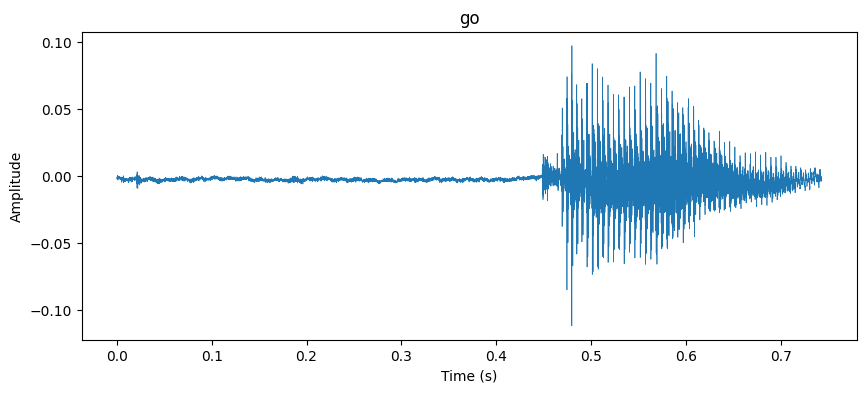

Audio playback


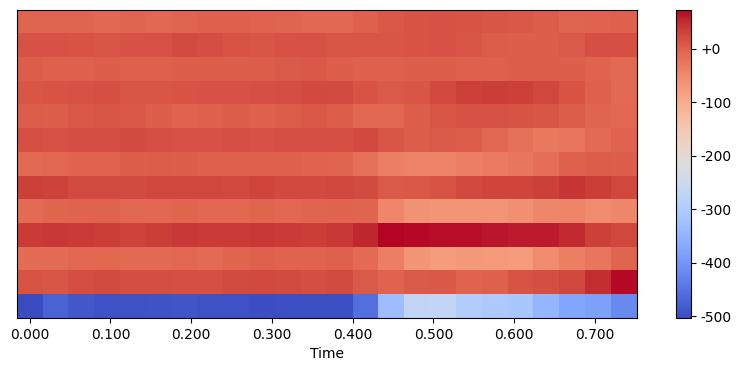

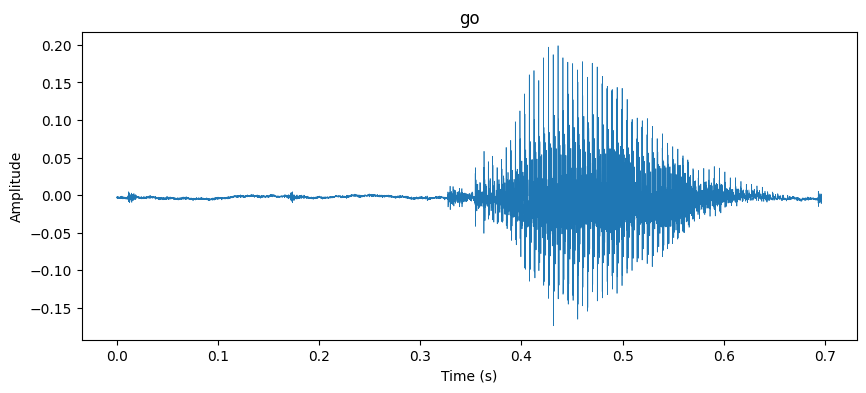

Audio playback


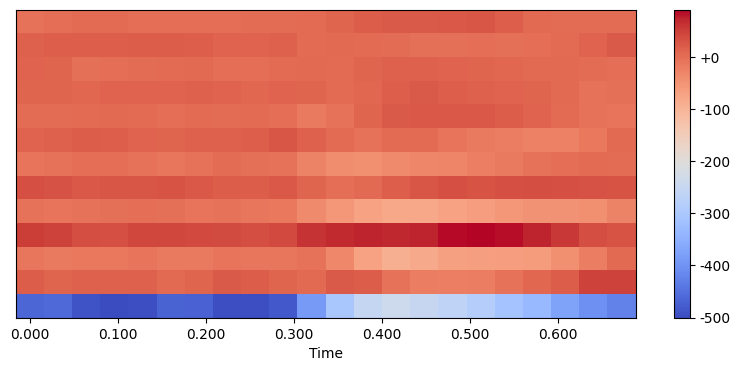

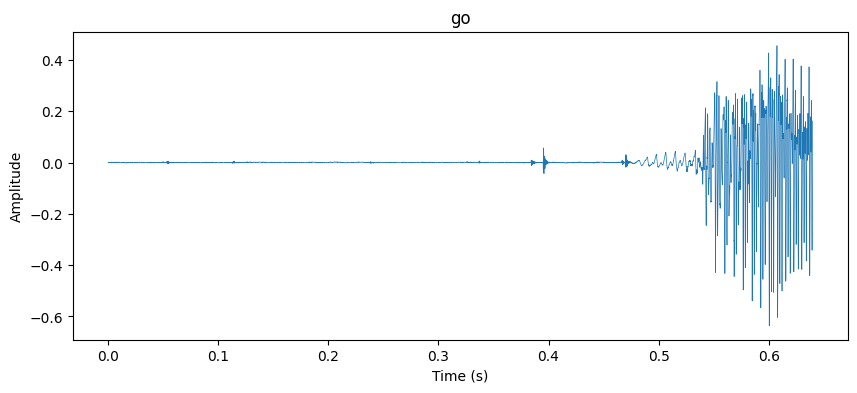

Audio playback


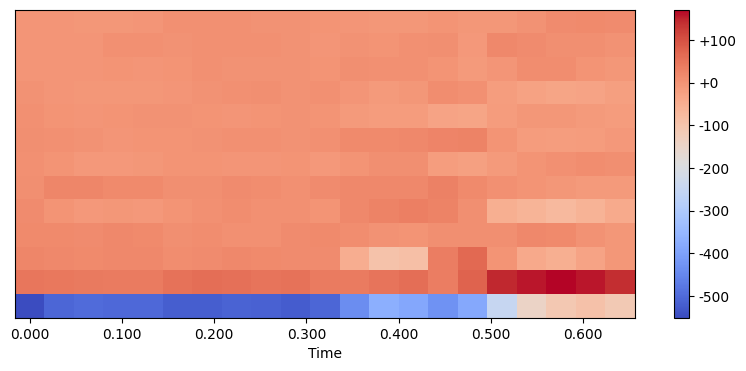

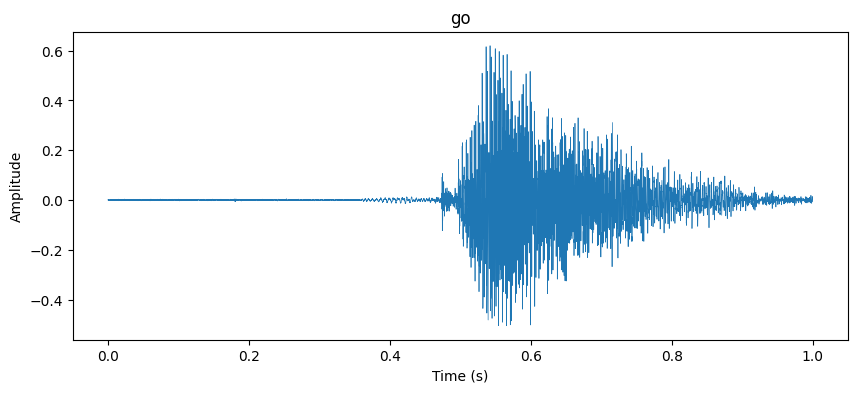

Audio playback


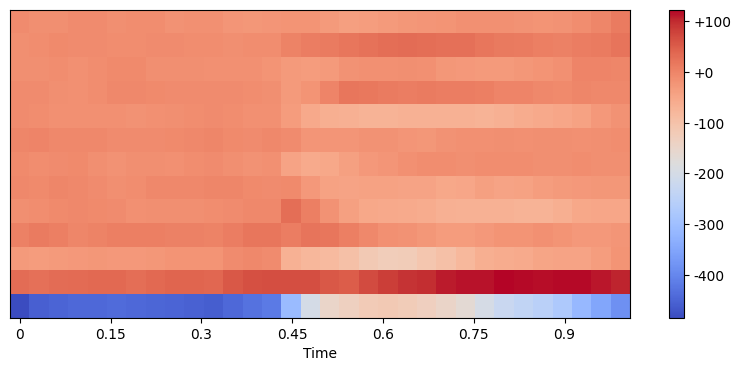

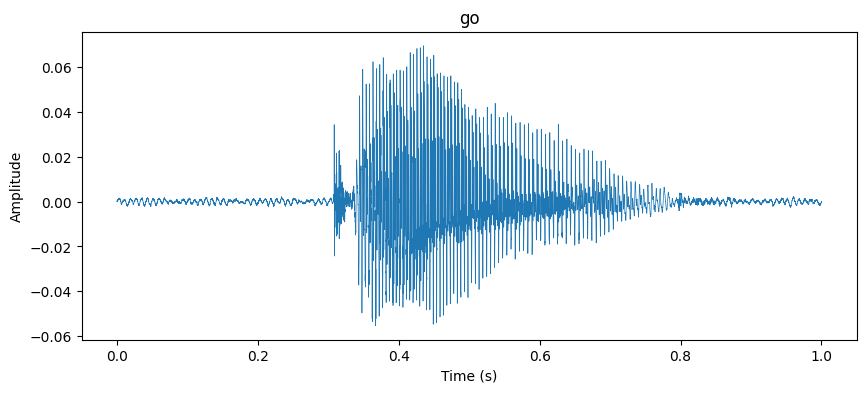

Audio playback


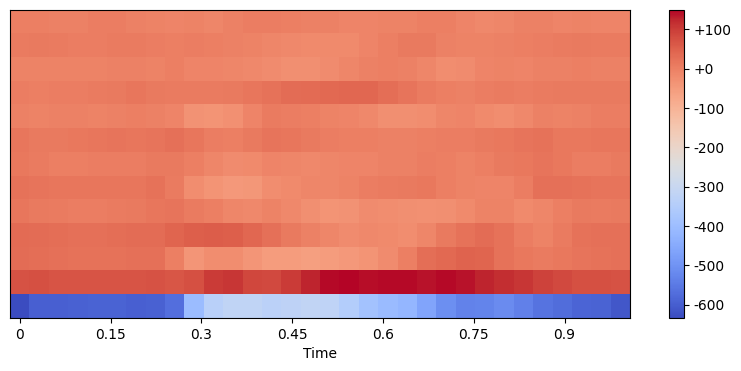

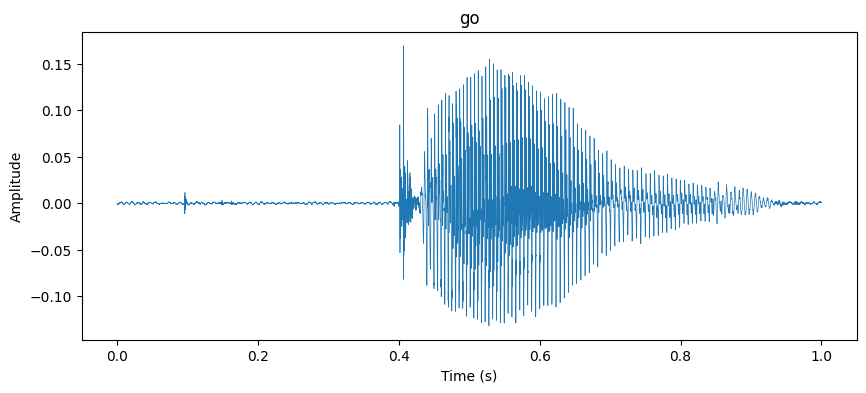

Audio playback


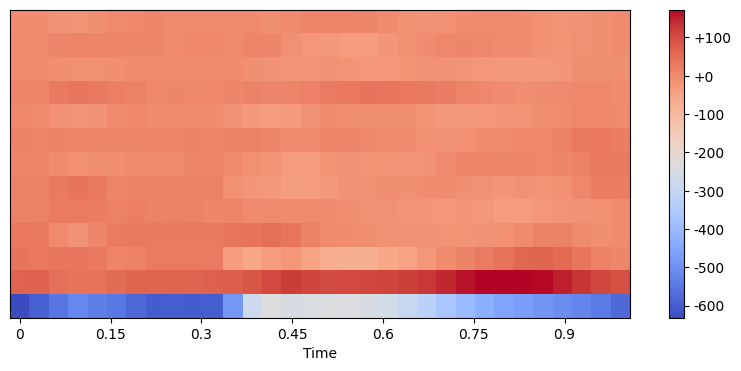

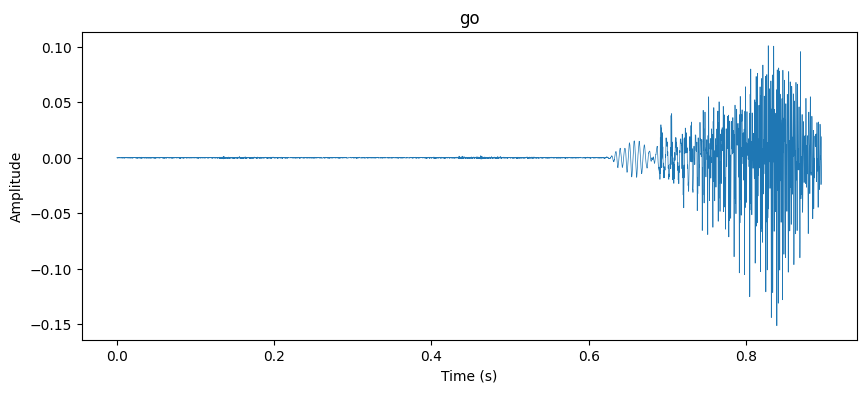

Audio playback


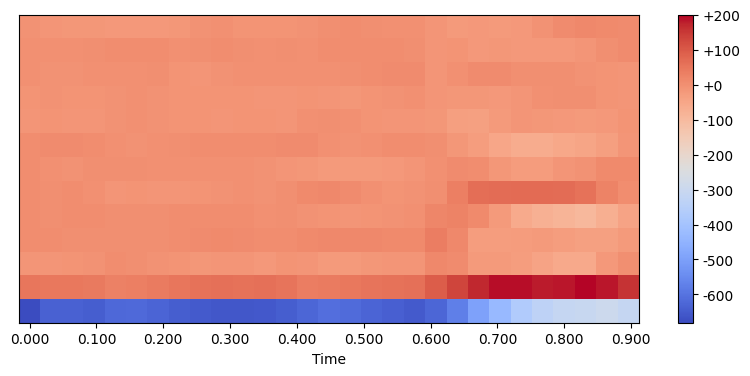

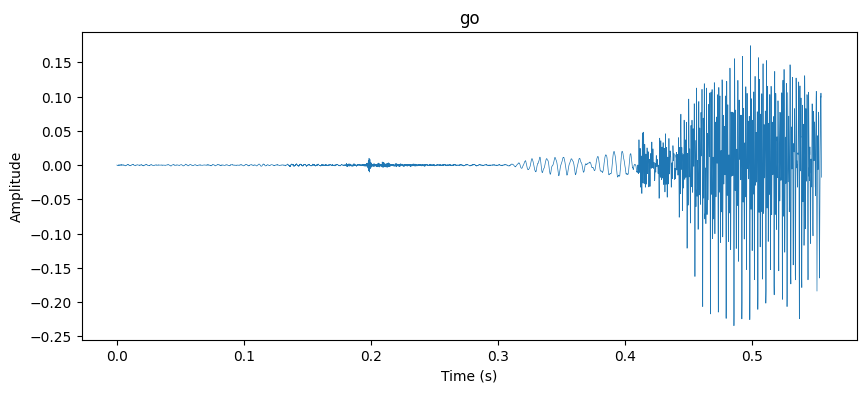

Audio playback


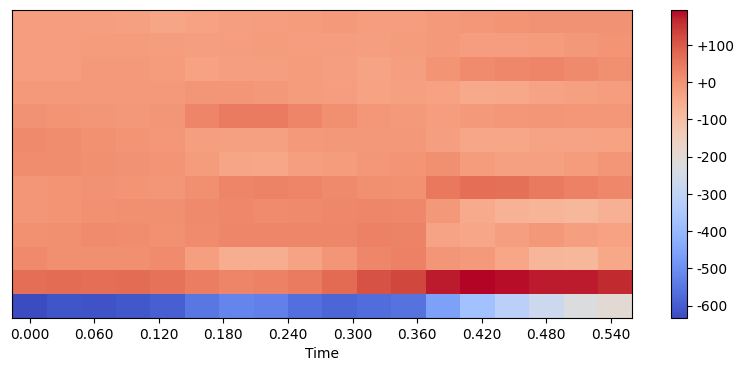

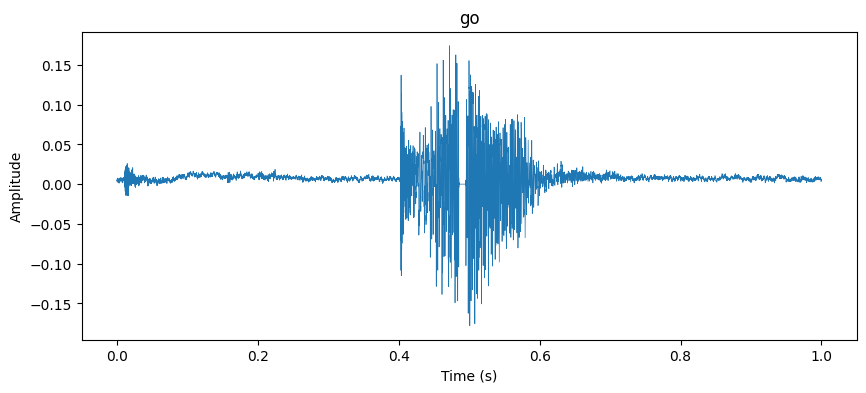

Audio playback


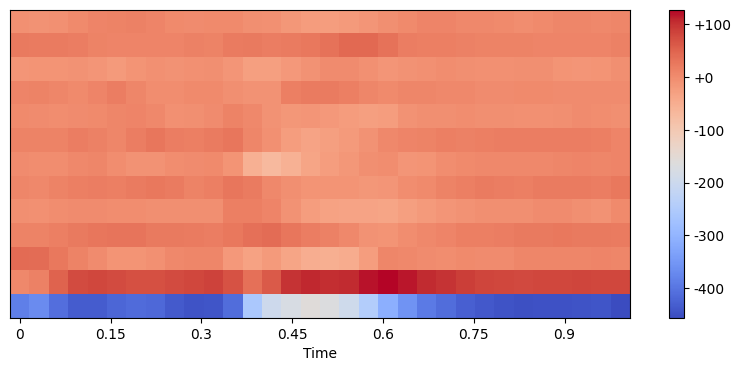

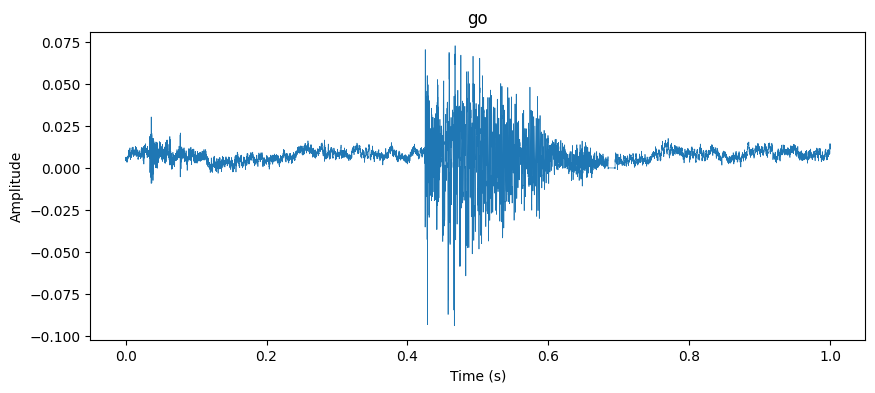

Audio playback


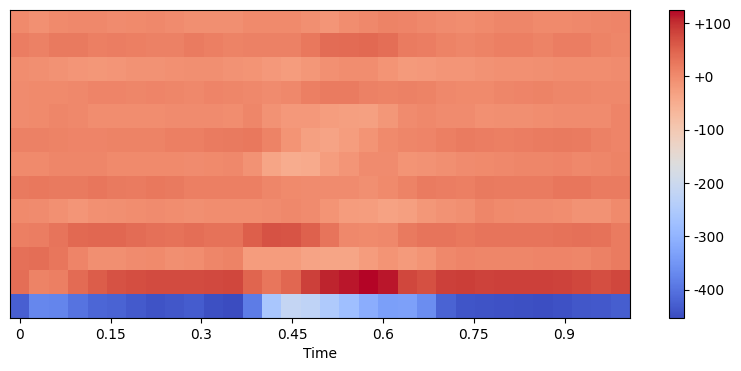

In [4]:
# Small demonstration on how the waveforms look like with their corresponding MFCCs
for i in range(10): 
    time = np.arange(0, len(wave[i])) / 16000
    
    # Plot the waveform
    plt.figure(figsize=(10, 4))
    plt.plot(time, wave[i], linewidth=0.5)
    plt.title(str(labels[i]))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()
    print('Audio playback')
    display.display(display.Audio(wave[i], rate=16000))
    plt.figure(figsize=(10,4))
    librosa.display.specshow(mfcc[i], 
                         x_axis="time",sr=16000
                         )
    plt.colorbar(format="%+2.f")
    plt.show()

Here, we spot the largest length of the mfccs present, so that we can pad the other mfccs with 0 in order to maintain uniformity in the length of each mfcc

In [5]:
#max_length=float('-inf')
#for i in mfcc:
#    print(len(i[0]))
#    max_length=max(max_length,len(i[0]))
#    print(max_length)


In [6]:
# Zero Padding the MFCCs so that the shape of each MFCCs remain constant  
labels=np.array(labels)
labels.shape
print(len(mfcc))
max_length=100 #for convenience
mfcc = [np.pad(mfc, ((0, 0), (0, max_length - len(mfc[0]))), mode='constant') if len(mfc[0])<max_length else mfc[:,:max_length] for mfc in mfcc]
print(len(mfcc))

22130
22130


Preparing the training and testing datasets

In [9]:
# We use Label Encoder to convert categorical data to numerical data
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

In [10]:
# Making Training and Testing datasets with a 80/20 split and shuffling enabled
X_train, X_test, y_train, y_test = train_test_split(
    mfcc, numeric_labels, test_size=0.2, random_state=42
)

In [11]:
# Making numpy array for reshaping
X_train=np.array(X_train)
X_test=np.array(X_test)

In [12]:
# Dimensions  will be ( Number of mfccs list, number of mfccs in each list, time frames for each mfcc list, extra dimension to act as a channel)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [13]:
X_train.shape

(17704, 13, 100, 1)

In [14]:
X_test.shape

(4426, 13, 100, 1)

In [15]:
# Dividing the testing dataset into validation and testing 
X_test,X_val=X_test[len(X_test)//2:],X_test[:len(X_test)//2]
y_test,y_val=y_test[len(y_test)//2:],y_test[:len(y_test)//2]
print(X_test.shape,X_val.shape)
print(y_test.shape,y_val.shape)

(2213, 13, 100, 1) (2213, 13, 100, 1)
(2213,) (2213,)


MAKING A SEQUENTIAL MODEL FOR CLASSIFICATION

In [47]:
# Making the model which is essentially a CNN with LSTM
# In this  model, Global Average Pooling is used to make an average off all the features  extracted
model = Sequential()

#FEATURE EXTRACTION
model.add(Conv2D(32, 3, activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2], 1),kernel_regularizer=l2(0.0001))) #L2 regularization adds a penalty term to the loss function, which is proportional to the square of the magnitude of the weights 
model.add(BatchNormalization()) # To normalize the data by re-centering and re-scaling
model.add(Conv2D(64, 3, activation='relu', padding='same',kernel_regularizer=l2(0.0001)))

model.add(Conv2D(128, 3, activation='relu', padding='same',kernel_regularizer=l2(0.0001)))
model.add(GlobalAveragePooling2D())# Give an output of 128 features in a row, averaged over the 128 filtered outputs we get from the previous Conv2D layer
model.add(Dropout(0.2))


model.add(Reshape((-1, 128)))  

model.add(LSTM(64, return_sequences=True)) # Helps in retaining the temporal dependencies and memorizes it for further training sets 

#CLASSIFICATION
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(len(set(numeric_labels)), activation='softmax')) # gives the probabilites of each label


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train the model

y=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100,callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=10),batch_size=64,)

# The number of epochs used here is 100, hence it takes a long time to have it trained

Epoch 1/100
277/277 [==============================] - 47s 163ms/step - loss: 1.6773 - accuracy: 0.2421 - val_loss: 1.5946 - val_accuracy: 0.2842
Epoch 2/100
277/277 [==============================] - 47s 170ms/step - loss: 1.5668 - accuracy: 0.2960 - val_loss: 1.5472 - val_accuracy: 0.3150
Epoch 3/100
277/277 [==============================] - 47s 169ms/step - loss: 1.5059 - accuracy: 0.3355 - val_loss: 1.4621 - val_accuracy: 0.3827
Epoch 4/100
277/277 [==============================] - 48s 172ms/step - loss: 1.4104 - accuracy: 0.4048 - val_loss: 1.3631 - val_accuracy: 0.4528
Epoch 5/100
277/277 [==============================] - 48s 173ms/step - loss: 1.3498 - accuracy: 0.4388 - val_loss: 1.3179 - val_accuracy: 0.4700
Epoch 6/100
277/277 [==============================] - 48s 174ms/step - loss: 1.2983 - accuracy: 0.4697 - val_loss: 1.2659 - val_accuracy: 0.5025
Epoch 7/100
277/277 [==============================] - 48s 175ms/step - loss: 1.2553 - accuracy: 0.4918 - val_loss: 1.2071 -

In [49]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc * 100:.2f}%')

70/70 [==============================] - 2s 22ms/step - loss: 0.2176 - accuracy: 0.9354
Test accuracy: 93.54%


Text(0, 0.5, 'Accuracy [%]')

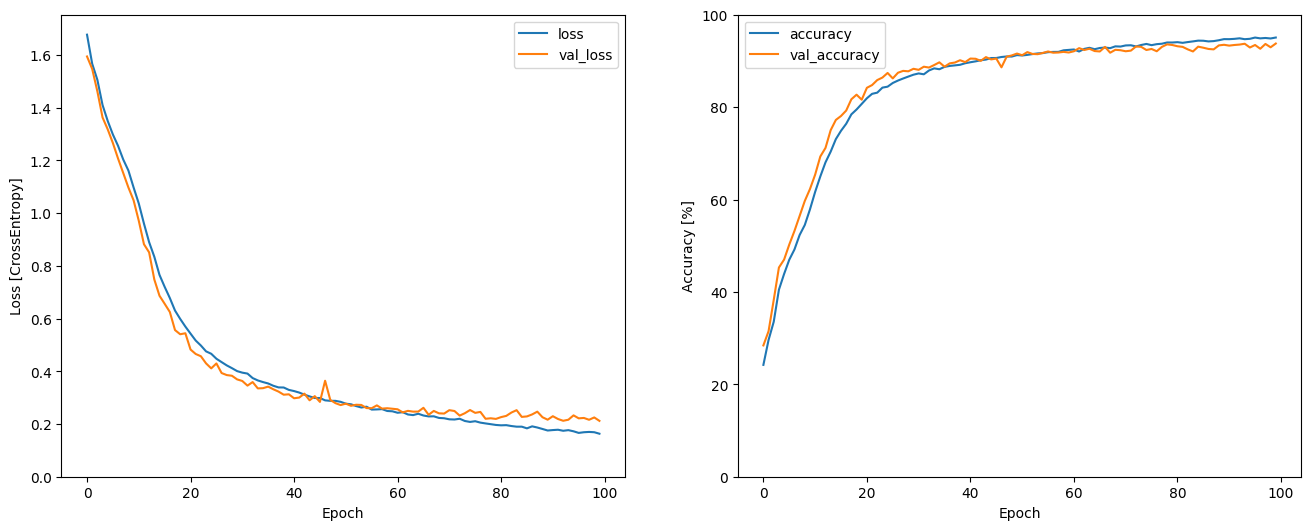

In [50]:
#Model metrics
metrics = y.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(y.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(y.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

70/70 [==============================] - 2s 21ms/step


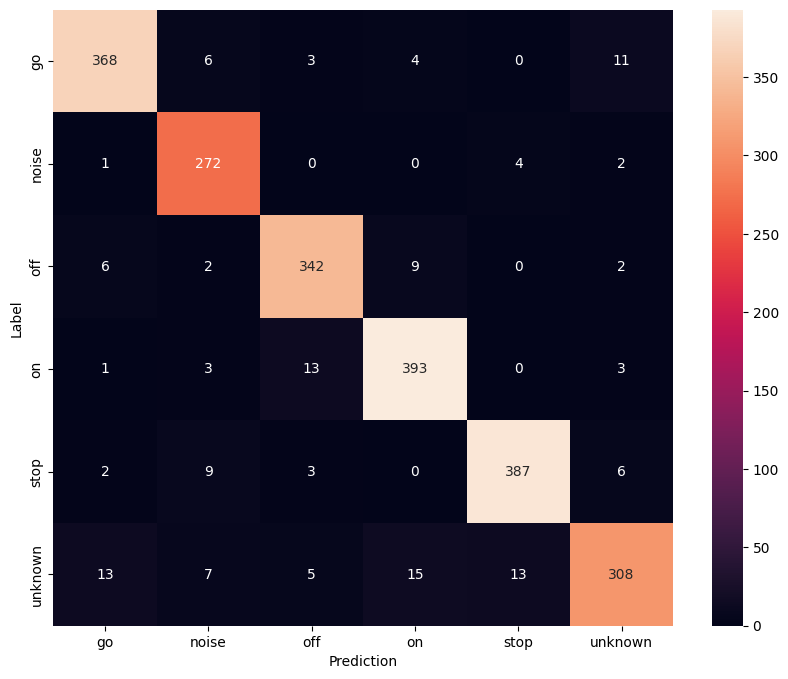

In [76]:
# Confusion Matrix
y_pred=model.predict(X_test)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(y_test, axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_list,
            yticklabels=label_list,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [51]:
# A second model is made where only Average Pooling is used. This model is faster than the previous, but has a tradeoff for performance 
model2 = Sequential()
model2.add(Conv2D(32, 3, activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2], 1),kernel_regularizer=l2(0.0001)))
model2.add(BatchNormalization())
model2.add(Conv2D(64, 3, activation='relu', padding='same',kernel_regularizer=l2(0.0001)))
model2.add(AveragePooling2D())
model2.add(Conv2D(128, 3, activation='relu', padding='same',kernel_regularizer=l2(0.0001)))
model2.add(AveragePooling2D())
model2.add(Dropout(0.2))


model2.add(Reshape((-1, 128)))  # Assuming 128 is the number of channels in the last Conv2D layer

model2.add(LSTM(64, return_sequences=True))


model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.25))
model2.add(Dense(len(set(numeric_labels)), activation='softmax'))


model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train the model
y=model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50,callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=10),batch_size=64,)



Epoch 1/50
277/277 [==============================] - 54s 187ms/step - loss: 1.2300 - accuracy: 0.5171 - val_loss: 0.8767 - val_accuracy: 0.6855
Epoch 2/50
277/277 [==============================] - 51s 184ms/step - loss: 0.7269 - accuracy: 0.7428 - val_loss: 0.6161 - val_accuracy: 0.7876
Epoch 3/50
277/277 [==============================] - 51s 184ms/step - loss: 0.5402 - accuracy: 0.8117 - val_loss: 0.4741 - val_accuracy: 0.8400
Epoch 4/50
277/277 [==============================] - 51s 184ms/step - loss: 0.4528 - accuracy: 0.8450 - val_loss: 0.4129 - val_accuracy: 0.8631
Epoch 5/50
277/277 [==============================] - 51s 186ms/step - loss: 0.4019 - accuracy: 0.8650 - val_loss: 0.3841 - val_accuracy: 0.8694
Epoch 6/50
277/277 [==============================] - 52s 187ms/step - loss: 0.3611 - accuracy: 0.8787 - val_loss: 0.3310 - val_accuracy: 0.8897
Epoch 7/50
277/277 [==============================] - 52s 189ms/step - loss: 0.3253 - accuracy: 0.8922 - val_loss: 0.2980 - val_ac

In [54]:
# Evaluate the model
test_loss, test_acc = model2.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc * 100:.2f}%')

70/70 [==============================] - 2s 32ms/step - loss: 0.2326 - accuracy: 0.9385
Test accuracy: 93.85%


Text(0, 0.5, 'Accuracy [%]')

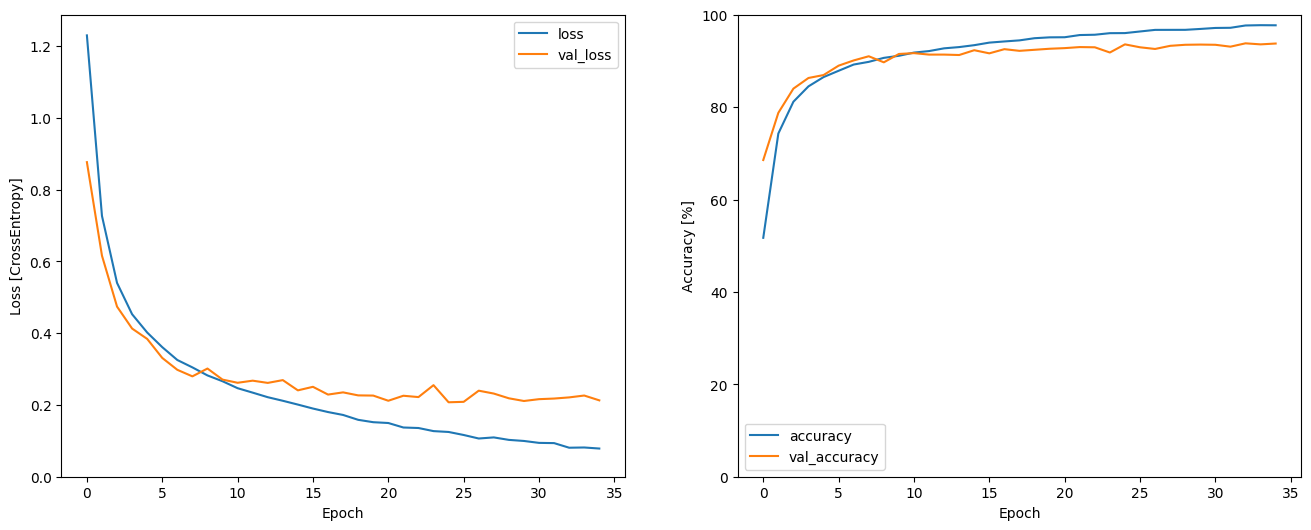

In [56]:
metrics = y.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(y.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(y.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

70/70 [==============================] - 2s 35ms/step


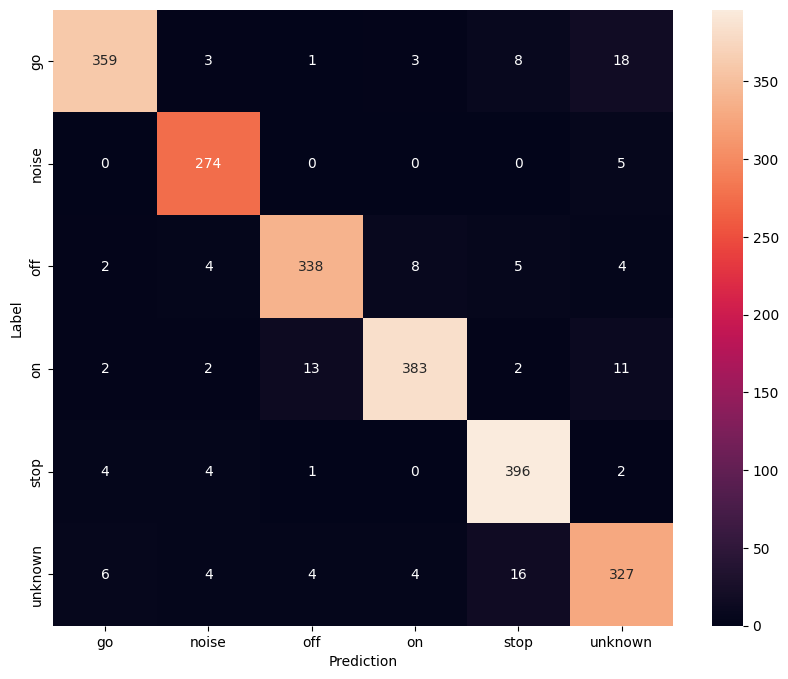

In [75]:
# Confusion Matrix
y_pred=model2.predict(X_test)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(y_test, axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_list,
            yticklabels=label_list,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Extracting mfcc from a single audio file and using it for prediction

In [ ]:
audio_file = str(input())# Input the PATH containing the audio file to be tested with
audio_file = pathlib.Path(audio_file)

signal,sr = librosa.load(audio_file,sr=16000)

mfccs = librosa.feature.mfcc(y = signal,n_mfcc=13,sr = sr)


max_length=100
if len(mfccs[0]) < max_length:
   mfccs = np.pad(mfccs, ((0, 0), (0, max_length - len(mfccs[0]))), mode='constant')
else:
   mfccs = mfccs[:, :max_length]

mfccs=mfccs.reshape(mfccs.shape[0], mfccs.shape[1], 1)

mfccs=np.array(mfccs)

mfccs=mfccs[np.newaxis,:]

mfccs.shape

In [ ]:
# Predicting using the first model
x=model.predict(mfccs)

plt.bar(label_list, tf.nn.softmax(x[0]))

plt.show()


In [ ]:
# Predicting using the second model
x=model2.predict(mfccs)

plt.bar(label_list, tf.nn.softmax(x[0]))

plt.show()



Saving the model using Keras saved model

In [69]:
model.save("saved_mfcc")
model2.save("saved_mfcc2")

INFO:tensorflow:Assets written to: saved_mfcc\assets


INFO:tensorflow:Assets written to: saved_mfcc\assets


INFO:tensorflow:Assets written to: saved_mfcc2\assets


INFO:tensorflow:Assets written to: saved_mfcc2\assets


In [77]:
loaded_model = models.load_model("saved_mfcc")
loaded_model2 = models.load_model("saved_mfcc2")

MAKING A REAL-TIME INFERENCING FOR THE ABOVE MODELS

In [79]:
FRAMES_PER_BUFFER = 3200
FORMAT = pyaudio.paInt16 # -32768 to 32767
CHANNELS = 1
RATE = 16000
p = pyaudio.PyAudio()

# Record a time interval for 1 second
def record():
 stream = p.open(
    format=FORMAT,
    channels=CHANNELS,
    rate=RATE,
    input=True,
    frames_per_buffer=FRAMES_PER_BUFFER
 )

 frames = []
 seconds = 1
 for i in range(0, int(RATE / FRAMES_PER_BUFFER * seconds)):
        data = stream.read(FRAMES_PER_BUFFER)#input from the user
        frames.append(data)
 stream.stop_stream()
 stream.close()
 return np.frombuffer(b''.join(frames), dtype=np.int16)

In [78]:
# making MFCC from the waveform obtained
def get_mfcc(audio):
    mfccs=librosa.feature.mfcc(y=numpy_array,sr=16000,n_mfcc=13)
    if len(mfccs[0]) < max_length:
       mfccs = np.pad(mfccs, ((0, 0), (0, max_length - len(mfccs[0]))), mode='constant')
    else:
       mfccs = mfccs[:, :max_length]
    mfccs=mfccs.reshape(mfccs.shape[0], mfccs.shape[1], 1)
    mfccs=np.array(mfccs)
    mfccs=mfccs[np.newaxis,:]
    return mfccs

In [80]:
# Making the MFCC's shape suitable to be an input for the models
def preprocessing(audio):
    audio=[i/32768 for i in audio]
    audio=np.array(audio)
    mfccs=librosa.feature.mfcc(y=audio,sr=16000,n_mfcc=13)
    
    if len(mfccs[0]) < max_length:
       mfccs = np.pad(mfccs, ((0, 0), (0, max_length - len(mfccs[0]))), mode='constant')
    else:
       mfccs = mfccs[:, :max_length]
    
    mfccs=mfccs.reshape(mfccs.shape[0], mfccs.shape[1], 1)
    mfccs=np.array(mfccs)
    mfccs=mfccs[np.newaxis,:]
    return mfccs

In [103]:
# Prediction function
def predict_mic():
    audio = record()
    spec = preprocessing(audio)
    prediction = loaded_model(spec)
    prediction2 = loaded_model2(spec)
    label_pred = np.argmax(prediction, axis=1)
    label_pred2 = np.argmax(prediction2, axis=1)
    command = label_list[label_pred[0]]
    command2 = label_list[label_pred2[0]]
    print('===============================================')
    print("Predicted label 1:", command)
    print("Predicted label 2:", command2)
    print('===============================================')
    return command

# MAIN FUNCTION
if __name__ == "__main__":
    while True:
        command=predict_mic()

Predicted label 1: noise
Predicted label 2: noise
Predicted label 1: noise
Predicted label 2: noise
Predicted label 1: noise
Predicted label 2: noise
Predicted label 1: on
Predicted label 2: on
Predicted label 1: stop
Predicted label 2: noise
Predicted label 1: off
Predicted label 2: off
Predicted label 1: noise
Predicted label 2: noise
Predicted label 1: go
Predicted label 2: go
Predicted label 1: noise
Predicted label 2: go
Predicted label 1: stop
Predicted label 2: stop
Predicted label 1: noise
Predicted label 2: noise
Predicted label 1: stop
Predicted label 2: stop
Predicted label 1: noise
Predicted label 2: noise
Predicted label 1: go
Predicted label 2: go
Predicted label 1: noise
Predicted label 2: noise
Predicted label 1: off
Predicted label 2: on
Predicted label 1: noise
Predicted label 2: noise
Predicted label 1: on
Predicted label 2: on
Predicted label 1: noise
Predicted label 2: noise
Predicted label 1: off
Predicted label 2: off
Predicted label 1: noise
Predicted label 2: n

KeyboardInterrupt: 